In [2]:
import os
import sys
import random
import cv2
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from model import *
#from model import data_generator
from config import Config
from dataset import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Test Input

ImageID: 11838, Image A_starfish/8cb87a26baedb3f9c8089392e8d1c5b9.jpg belongs to class  starfish and bbox is [0.0, 0.0, 413.0, 523.0]
This sample doesn't have its own attribute annotation.
0.8205013201408802 0.8205013201408802
[-16.0, -16.0, 240.0, 240.0]
True
********************************************************************************


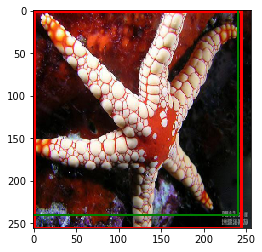

In [33]:
if sys.platform == 'darwin':
    data_path = os.path.join(os.getcwd(), '../data/train_test_a/zsl_a_animals_train_20180321')
else:
    data_path = os.path.join(os.getcwd(), '../cai_zsl/data/train_test_a/zsl_a_animals_train_20180321')
test_dataset = CAIData(root_dir=data_path, mode="train")
test_dataset.prepare()

#anchors = utils.generate_anchors(scales=[32, 64, 128, 256], ratios=[0.5, 2], shape=[8, 8], feature_stride=32, anchor_stride=1)
anchors = []
feature_strides = []
config = Config()
for i, scale in enumerate(config.ANCHOR_SCALES):
    scale_anchors = utils.generate_anchors(scales=scale, ratios=config.ANCHOR_RATIOS, shape=[8*2**i, 8*2**i],
                                          feature_stride=config.FEATURE_STRIDE/(2**i), anchor_stride=1)
    anchors.append(scale_anchors)
    feature_strides += [config.FEATURE_STRIDE/(2**i)]*scale_anchors.shape[0]
anchors = np.concatenate(anchors, axis=0)

test_id = random.sample(test_dataset.image_ids, 1)[0]

config = Config()
test_image, test_image_shape = test_dataset.load_image(test_id)
test_bbox, _, _, _ = test_dataset.load_bbox_class_attr(test_id)
test_dataset.print_image_info(test_id)
translated_bbox = translate_bbox(test_bbox, input_shape=test_image_shape[:2], output_shape=config.IMAGE_SHAPE[:2])

# feature_stride = float(config.FEATURE_STRIDE)

gt_target_object = np.zeros(anchors.shape[0]).astype("float32")
gt_target_bbox = np.zeros((anchors.shape[0], 4)).astype("float32")

y1, x1, y2, x2 = translated_bbox
assert x2>x1 and y2>y1
x, y, w, h = x1, y1, x2-x1, y2-y1
xc, yc = x + w/2, y + h/2

translated_bbox = [x1, y1, x2, y2]

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, aspect='equal')
ax2.imshow(cv2.resize(test_image, tuple(config.IMAGE_SHAPE[:2])))
ax2.add_patch(
            patches.Rectangle(
                (x, y),
                w,
                h,
                fill=False,      # remove background
                edgecolor = "red",
                linewidth = 3
            )
        )

cnt = 0
iou_test = []
iou_data = []
max_iou = 0.0
max_patch = []
for i, anchor in enumerate(anchors):
    #feature_stride = feature_strides[i]
    py, px, ph, pw, feature_stride = anchor
    assert feature_stride == feature_strides[i], "Inconsistent feature stride"
    
    py += feature_stride/2
    px += feature_stride/2
    px1, py1, px2, py2 = px-pw/2, py-ph/2, px+pw/2, py+ph/2
    
    iou_data.append(iou(translated_bbox, [px1, py1, px2, py2]))

    if iou(translated_bbox, [px1, py1, px2, py2]) > 0.0:
        # calculate tx, ty, tw, th
        tx = (xc - px + feature_stride/2)/feature_stride
        ty = (yc - py + feature_stride/2)/feature_stride
        tw = np.log(w/float(pw))
        th = np.log(h/float(ph))
        
#         ax2.add_patch(
#             patches.Rectangle(
#                 (px1, py1),
#                 px2-px1,
#                 py2-py1,
#                 fill=False,      # remove background
#                 edgecolor = "blue"
#             )
#         )
        iou_test.append(iou(translated_bbox, [px1, py1, px2, py2]))
        gt_target_object[i] = 1.0
        gt_target_bbox[i] = [tx, ty, tw, th]
        cnt += 1

        if 0 <= tx <= 1 and 0 <= ty <= 1:
            if iou_test[-1] > max_iou:
                max_patch = [px1, py1, px2, py2]
                max_iou = iou_test[-1]
            
#             gt_target_object[i] = 1.0
#             gt_target_bbox[i] = [tx, ty, tw, th]
#             cnt += 1
px1, py1, px2, py2 = max_patch
ax2.add_patch(
                patches.Rectangle(
                    (px1, py1),
                    px2-px1,
                    py2-py1,
                    fill=False,      # remove background
                    edgecolor = "green",
                    linewidth= 2
                )
            )

print(max_iou, max(iou_test))
print(max_patch)
print(max(iou_test) == max_iou)
print("*"*80)

assert cnt > 0, print(cnt)

### Model configuration

In [7]:
config = Config()
model = ZSL(mode="training", config=config, model_dir="./model/")

In [8]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_conv1 (Conv2D)            (None, 256, 256, 32) 896         input_image[0][0]                
__________________________________________________________________________________________________
leaky_re_lu_139 (LeakyReLU)     (None, 256, 256, 32) 0           input_conv1[0][0]                
__________________________________________________________________________________________________
input_conv2 (Conv2D)            (None, 128, 128, 64) 18496       leaky_re_lu_139[0][0]            
__________________________________________________________________________________________________
leaky_re_l

### Dataset

In [37]:
if sys.platform == 'darwin':
    data_path = os.path.join(os.getcwd(), '../data/train_test_a/zsl_a_animals_train_20180321')
else:
    data_path = os.path.join(os.getcwd(), '../cai_zsl/data/train_test_a/zsl_a_animals_train_20180321')
    
train_dataset = CAIData(root_dir=data_path, mode="train")
train_dataset.prepare()

val_dataset = CAIData(root_dir=data_path, mode="validation")
val_dataset.prepare()

### Train the model

In [ ]:
model.train(train_dataset, val_dataset, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1)


Starting at epoch 0. LR=0.001

Checkpoint Path: ./model/challengerai20180502T2102/yolo_challengerai_{epoch:04d}.h5


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


### Test detection output

In [ ]:
model = ZSL(mode="detection", config=config, model_dir="./model/")
model.load_weights("./model/")

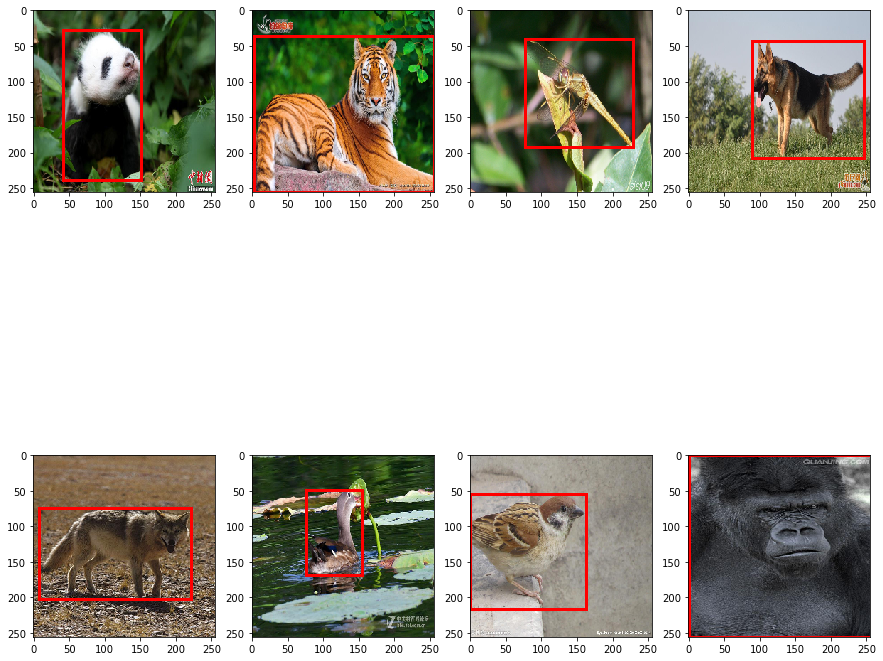

In [42]:
images = []
image_ids = []
for i in range(config.BATCH_SIZE):
    random_id = random.sample(train_dataset.image_ids, 1)[0]
    image, image_shape = train_dataset.load_image(random_id)
    images.append(image)
    image_ids.append(random_id)

# detection
output_boxes = model.detect(images, verbose=True)

# visualize output bounding boxes
fig2 = plt.figure(figsize=(15,15))
for i, image_id in enumerate(image_ids):
    image = images[i]
    
    # ground truth
    image_bbox, _, _, _ = train_dataset.load_bbox_class_attr(image_id)
    translated_bbox = translate_bbox(image_bbox, input_shape=image.shape[:2], output_shape=config.IMAGE_SHAPE[:2])
    y1, x1, y2, x2 = translated_bbox
    assert x2 > x1 and y2 > y1
    x, y, w, h = x1, y1, x2-x1, y2-y1
    
    ax2 = fig2.add_subplot(241+i, aspect='equal')
    ax2.imshow(cv2.resize(image, tuple(config.IMAGE_SHAPE[:2])))
    ax2.add_patch(
                patches.Rectangle(
                    (x, y),
                    w,
                    h,
                    fill=False,      # remove background
                    edgecolor = "red",
                    linewidth = 1
                )
            )
    
    # detection
    x1, y1, x2, y2 = output_boxes[i]
    assert x2 > x1 and y2 > y1
    x, y, w, h = x1, y1, x2-x1, y2-y1
    ax2.add_patch(
                patches.Rectangle(
                    (x, y),
                    w,
                    h,
                    fill=False,      # remove background
                    edgecolor = "green",
                    linewidth = 3
                )
            )